In [1]:
import pandas as pd, numpy as np, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px, pickle, plotly.graph_objects as go
from sklearn.svm import SVC
from tqdm import tqdm
from matplotlib.pyplot import *
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from numpy.random import choice



In [2]:

## A misguided attempt at an interesting solution, until I realized 
## I didn't even need to do it this way at all
# class ClfSwitcher(BaseEstimator):

#     def __init__(
#         self, 
#         estimator = SVC(),
#     ):
#         """
#         A Custom BaseEstimator that can switch between classifiers.
#         :param estimator: sklearn object - The classifier
#         """ 

#         self.estimator = estimator


#     def fit(self, X, y=None, **kwargs):
#         self.estimator.fit(X, y)
#         return self


#     def predict(self, X, y=None):
#         return self.estimator.predict(X)


#     def predict_proba(self, X):
#         return self.estimator.predict_proba(X)


#     def score(self, X, y):
#         return self.estimator.score(X, y)

In [3]:
# Pipe = Pipeline([('scaling',StandardScaler()), ('clf',ClfSwitcher())])


# Params = [
#     {
#         'clf__estimator':[SVC(probability=True)],
#         'scaling':['passthrough',StandardScaler(),RobustScaler(),MinMaxScaler()],
#         'clf__estimator__kernel' : ['rbf'],
#         'clf__estimator__gamma': [.1,1],
#         'clf__estimator__C':[0,.1]
#     }
# ]

In [4]:
train_x = pd.read_csv('Data/X_train.csv',header=None).values
train_y = pd.read_csv('Data/y_train.csv',header=None).values.reshape(-1)
test_x = pd.read_csv('Data/X_test.csv',header=None).values
test_y = pd.read_csv('Data/y_test.csv',header=None).values.reshape(-1)

In [5]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
res_dir = Path('results')
res_dir.mkdir(exist_ok=True)
train_model = False
save = True

In [6]:
def load_model(model,loc=out_dir):
    filname = list(Path(loc).rglob('*'+model+'*'))
    if len(filname) == 0:
        raise ValueError("Can't find the file!")
    if len(filname) >1:
        raise ValueError("Located too many items matching that search. Please try again. We found: {}".format(filname))
    filname = filname[0]
    with open(filname,'rb') as fil:
        temp = pickle.load(fil)
    return temp

def seaborn_friendly(res):
    res['mean_score'] = res[['mean_train_score','mean_test_score']].values.tolist()
    res['type'] = [['train','test']]*res.shape[0]
    res['std_score'] = res[['std_train_score','std_test_score']].values.tolist()
    res = res.explode(['mean_score','type','std_score'],ignore_index=True)
    return res

def plot_cv_param_res(res,xs, param, save=False, out_dir = '.',key='model', y='mean_score'):
    test = seaborn_friendly(res)
    if isinstance(xs,str):
        xs = [xs] 
    for x in xs:
        ax = sns.lineplot(x=x, y=y,hue=param,style='type',data=test)
        ax.set(title="{} {} by {}".format(key.upper(),y,param))
        if save:
            ax.get_figure().savefig(Path(out_dir,f"{param}_{y}_{x}.png"))
        show()

In [7]:
np.logspace(-5,2,15)

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02])

In [8]:
np.linspace(0,5,16)[1:]

array([0.33333333, 0.66666667, 1.        , 1.33333333, 1.66666667,
       2.        , 2.33333333, 2.66666667, 3.        , 3.33333333,
       3.66666667, 4.        , 4.33333333, 4.66666667, 5.        ])

In [9]:
if train_model:

    svm_grids = {
            'clf__kernel':['rbf','sigmoid','poly'],
            'clf__gamma':np.linspace(0,2,11)[1:],
            'clf__C':np.linspace(0,2,11)[1:]
        }
    svm_pipe = Pipeline([('scaler',StandardScaler()),('clf',SVC(probability=True, max_iter=500, degree=3))])
    svm_cv = GridSearchCV(svm_pipe, svm_grids, n_jobs=-1, verbose=10, cv=4, return_train_score=True)
    svm_cv.fit(train_x, train_y)
    with open(Path(out_dir, 'svm_cv.pkl'),'wb') as fil:
        pickle.dump(svm_cv,fil)
    del svm_cv
    del svm_pipe

    mlp_grid = {
            'clf__hidden_layer_sizes' : [[64,16,8],[128,64,64,32],[128,128,64,64]],
            'clf__alpha': [0, .0001,.001,.01,.1],
            'clf__learning_rate_init':[.0001, .001,.01,.1]
        }
    mlp_pipe = Pipeline([('scaler',StandardScaler()),('clf',MLPClassifier())])
    mlp_cv = GridSearchCV(mlp_pipe, mlp_grid, n_jobs=-1, verbose=10, cv=4, return_train_score=True)
    mlp_cv.fit(train_x, train_y)
    with open(Path(out_dir, 'mlp_cv.pkl'),'wb') as fil:
        pickle.dump(mlp_cv,fil)
    del mlp_cv
    del mlp_pipe

In [10]:
#Total runtime of final attempt was 8h  35m 33.5s

In [11]:
def analyze(key, x, test_x, test_y, save=False, out_dir='.', loc=out_dir):
    model_res = load_model(key,loc=loc)
    df =  pd.DataFrame.from_dict(model_res.cv_results_)
    if 'knn' in key:
        #Bootlegged solution to an annoying naming problem
        df.loc[~df['param_weights'].isin(['uniform','distance']),'param_weights'] = 'rbf'
    if 'rf' in key:
        #Switch out the value with no limit of depth to be in line with the others, but slightly separated to notice it better.
        mask = df['param_max_depth'].isna()
        df.loc[mask,'param_max_depth'] = df.loc[~mask, 'param_max_depth'].max()+2*df.loc[~mask, 'param_max_depth'].diff().max()
    if 'mlp' in  key:
        df['param_clf__hidden_layer_sizes'] = df['param_clf__hidden_layer_sizes'].astype(str)
    ys = df.filter(regex='param').columns
    model_res_dir = Path(out_dir,key)
    if save:
        model_res_dir.mkdir(exist_ok=True)
    if isinstance(x,str):
        droppables = [x,'params']
    else:
        droppables = x + ['params']
        contour_continuous(df,x[0],x[1],'{} Continuous Test Accuracy'.format(key.upper()), save=save, out_dir=model_res_dir)
    ys = ys.drop(droppables)
    for param in ys:
        plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key)
        plot_cv_param_res(df, x, param, save=save, out_dir=model_res_dir, key = key,y='mean_fit_time')
    best_res = handle_best(key, test_x, test_y, save=save, out_dir=model_res_dir)
    return df, best_res
    
def contour_continuous(df, x, y, title='placeholder',save = False, out_dir='.'):
    fig = go.Figure(data= go.Contour(z=df['mean_test_score'],x=df[x],y = df[y]))
    fig.update_layout(title=title, xaxis_title=x, yaxis_title=y)
    if save:
        plotly.offline.plot(fig, filename=str(Path(out_dir,'contour.html')),auto_open=False)
    fig.show()

def handle_best(key, test_x, test_y, save=False, out_dir = out_dir):
    res = load_model(key)
    best_model = res.best_estimator_    
    df =  pd.DataFrame.from_dict(res.cv_results_)
    best_res = df.iloc[res.best_index_]
    best_res['best_final_test'] = best_model.score(test_x,test_y)
    best_res['best_cv_test'] = res.cv_results_['mean_test_score'][res.best_index_]
    best_res['best_cv_train'] = res.cv_results_['mean_train_score'][res.best_index_]
    if save:
        print(out_dir)
        best_res.to_csv(Path(out_dir,'{}_best_results.csv'.format(key)))
        best_res.to_latex(Path(out_dir,'{}_best_results.tex'.format(key)))
    return best_res

def wrap_up(res_dir):
    df = pd.concat([pd.read_csv(i,index_col=0,names=[i.name.split('_')[0]],header=None) for i in res_dir.rglob("*best_results.csv")],axis=1).dropna()
    df.rename(index={df.index[0]:'Index'},inplace=True)
    df.to_csv(Path(res_dir,'all_best.csv'),float_format='%.4f')
    df.to_latex(Path(res_dir,'all_best.tex'),float_format='%.4f')

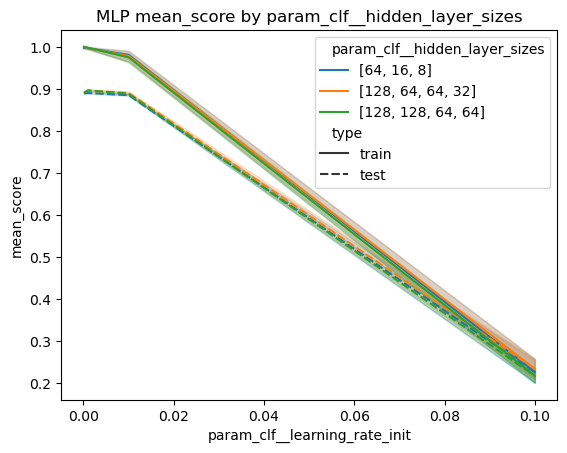

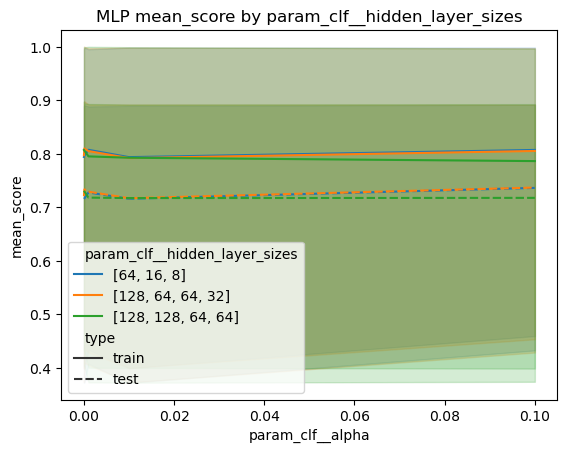

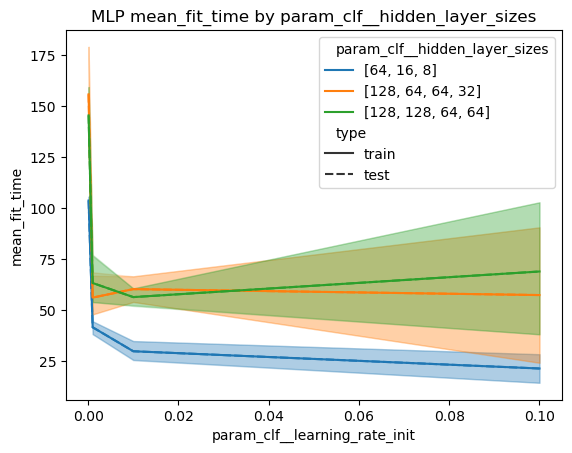

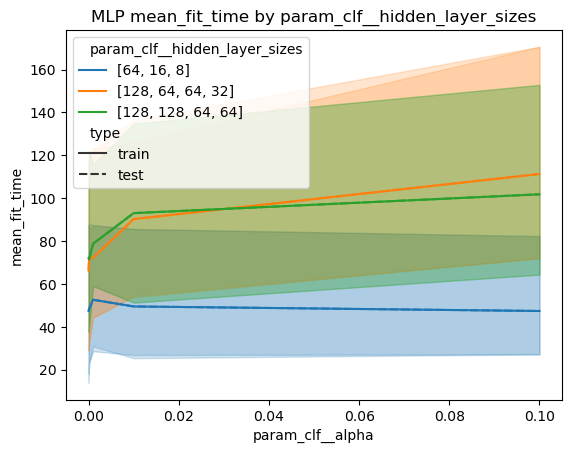

results/mlp


/tmp/ipykernel_431/1908249661.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_431/1908249661.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_431/1908249661.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_431/1908249661.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

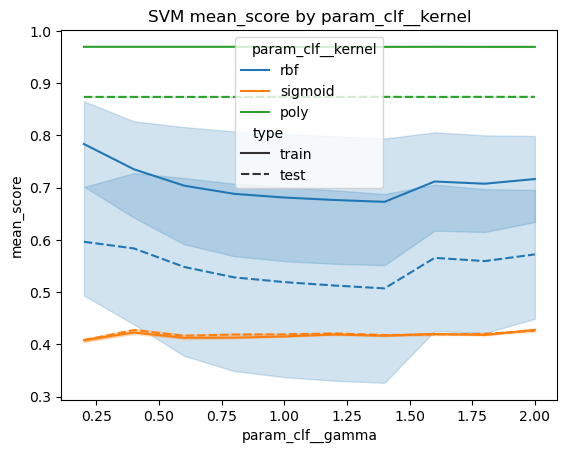

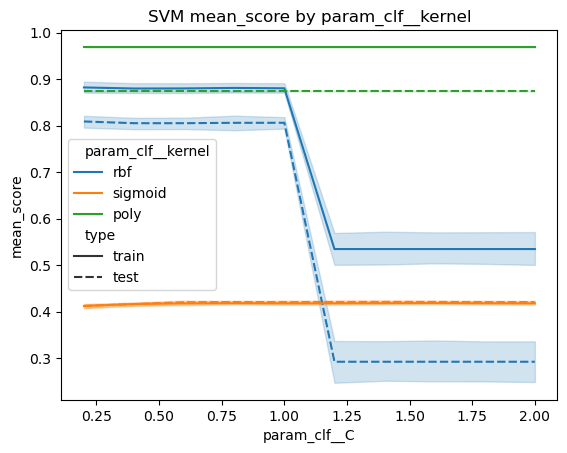

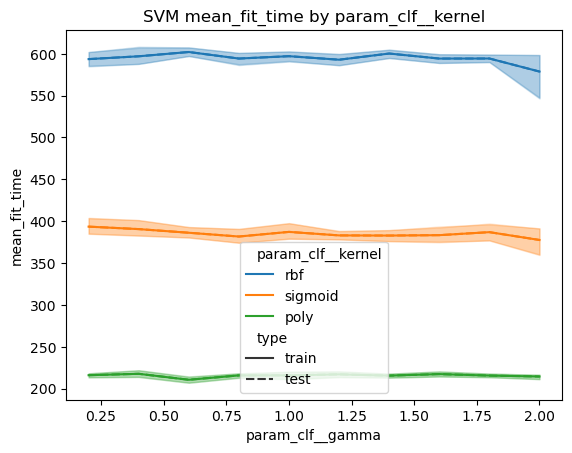

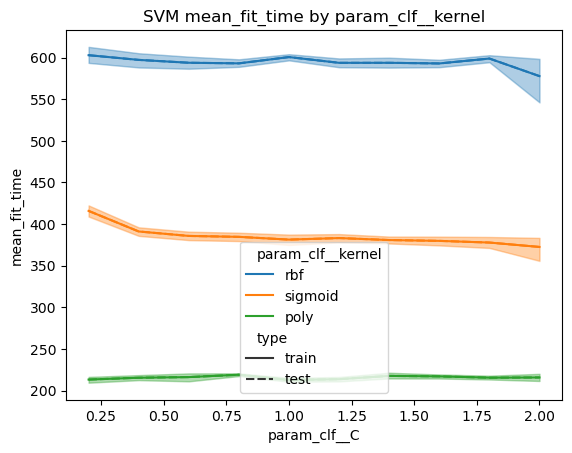

results/svm


/tmp/ipykernel_431/1908249661.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_431/1908249661.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_431/1908249661.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_431/1908249661.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [12]:
keys = ['mlp','svm']
xs = [['param_clf__learning_rate_init','param_clf__alpha'],['param_clf__gamma','param_clf__C']]
df_dict = {}
for key, x in zip(keys,xs):
    temp = analyze(key,x, test_x, test_y, save=save, out_dir=res_dir)
    if key not in df_dict.keys():
        df_dict[key] = temp
#This is to combine the resulting best data into one table for everything
if save:
    wrap_up(res_dir)

In [13]:
svm = load_model('svm').best_estimator_
mlp = load_model('mlp').best_estimator_

In [14]:
svm_proba = svm.predict_proba(test_x)
mlp_proba = mlp.predict_proba(test_x)


In [15]:
df = pd.DataFrame(columns=['class'], data=test_y)

In [16]:
def typemap_func(row):
    typemap = np.array([['Neither Difficult', 'SVM Difficult'], ['MLP Difficult', 'Both Difficult']])
    return typemap[int(row['mlp_diff']),int(row['svm_diff'])]

In [17]:
df['svm_proba'] = svm_proba[np.arange(svm_proba.shape[0]),df['class'].values]
df['svm_call'] = svm_proba.argmax(axis=1)
df['svm_diff'] = df['svm_call'] != df['class']
df['mlp_proba'] = mlp_proba[np.arange(mlp_proba.shape[0]),df['class'].values]
df['mlp_call'] = mlp_proba.argmax(axis=1)
df['mlp_diff'] = df['mlp_call'] != df['class']
df['type'] = df.apply(typemap_func,axis=1)
df['classname'] = df['class'].map({0:'Top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat'})
df['mean_proba'] = (df['svm_proba']+df['mlp_proba'])/2

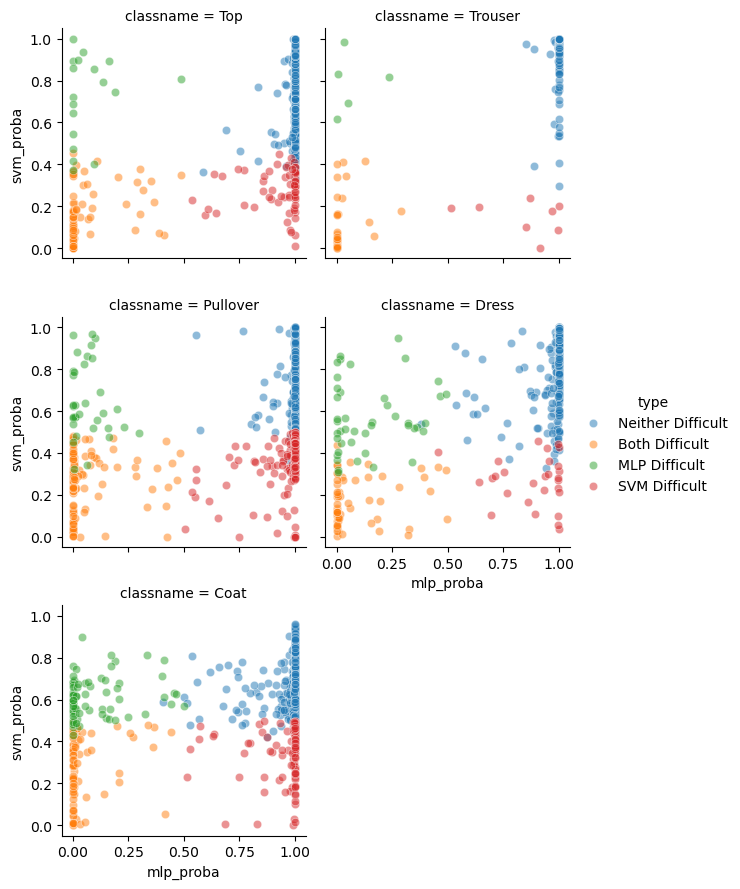

In [18]:
table = sns.FacetGrid(df, col = 'classname',col_wrap=2, hue="type")
table.map(sns.scatterplot,"mlp_proba","svm_proba",alpha=.5)
table.add_legend()
if save:
    #plotly.offline.plot(table,filename=str(Path(res_dir,'difficult.html')), auto_open=False)
    table.savefig(Path(res_dir,'difficulties.png'))
show()

In [19]:
plottable = df.reset_index().sort_values('mean_proba',ascending=False).loc[df['type']!= 'Neither Difficult'].groupby(['classname','type']).first().reset_index()
if save:
    plottable.to_csv(Path(res_dir,'plot_table.csv'),index=False)
    plottable.to_latex(Path(res_dir,'plot_table.tex'),index=False)

/tmp/ipykernel_431/3454126106.py:4: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



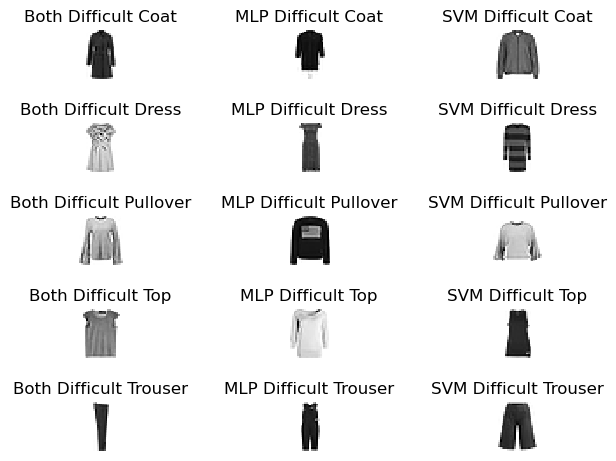

In [20]:
fig, axes = subplots(nrows=5,ncols=3)
fig.tight_layout()
for idx, row in plottable.iterrows():
    ax = axes[idx//3,idx%3]
    ax.set_axis_off()
    image = test_x[row['index']].reshape(28,28)
    ax.imshow(image,cmap=cm.gray_r,interpolation="nearest")
    ax.set_title(f"{row['type']} {row['classname']}")
if save:
    fig.savefig(Path(res_dir,'Types_images'),bbox_inches='tight')

In [21]:
plottable.sort_values('class')

classname            type  index  class  svm_proba  svm_call  svm_diff  \
9        Top  Both Difficult    436      0   0.347538         3      True   
10       Top   MLP Difficult    921      0   0.807085         0     False   
11       Top   SVM Difficult    137      0   0.429797         3      True   
12   Trouser  Both Difficult   1070      1   0.414774         3      True   
13   Trouser   MLP Difficult   1914      1   0.815975         1     False   
14   Trouser   SVM Difficult   1974      1   0.202755         4      True   
6   Pullover  Both Difficult   2801      2   0.399679         4      True   
7   Pullover   MLP Difficult   2544      2   0.967783         2     False   
8   Pullover   SVM Difficult   2877      2   0.498955         4      True   
3      Dress  Both Difficult   3441      3   0.316876         0      True   
4      Dress   MLP Difficult   3810      3   0.947275         3     False   
5      Dress   SVM Difficult   3382      3   0.440828         4      True   
0       Coat  Both Difficult   4110      4   0.442786         3      True   
1       Coat   MLP Difficult   4410      4   0.788874         4     False   
2       Coat   SVM Difficult   4695      4   0.498579         2      True   

    mlp_proba  mlp_call  mlp_diff  mean_proba  
9    0.487817         3      True    0.417677  
10   0.488846         2      True    0.647965  
11   0.983014         0     False    0.706405  
12   0.128738         3      True    0.271756  
13   0.236740         3      True    0.526357  
14   1.000000         1     False    0.601378  
6    0.485677         4      True    0.442678  
7    0.087898         4      True    0.527840  
8    0.999956         2     False    0.749456  
3    0.493340         0      True    0.405108  
4    0.277057         1      True    0.612166  
5    0.999520         3     False    0.720174  
0    0.443113         3      True    0.442950  
1    0.411459         2      True    0.600166  
2    0.999999         4     False    0.749289

In [22]:
df.groupby(['type','classname']).count()['svm_proba']

type               classname
Both Difficult     Coat          84
                   Dress         59
                   Pullover     112
                   Top           70
                   Trouser       30
MLP Difficult      Coat          78
                   Dress         44
                   Pullover      34
                   Top           18
                   Trouser        5
Neither Difficult  Coat         730
                   Dress        869
                   Pullover     617
                   Top          845
                   Trouser      957
SVM Difficult      Coat         108
                   Dress         28
                   Pullover     237
                   Top           67
                   Trouser        8
Name: svm_proba, dtype: int64

In [23]:
full_table = plottable[['classname','type','index']].copy()
namedict = {0:'Top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat'}
for key in namedict:
    full_table[f'svm_{namedict[key]}'] = svm_proba[full_table['index'],key]
for key in namedict:
    full_table[f'mlp_{namedict[key]}'] = mlp_proba[full_table['index'],key]
if save:
    full_table.to_csv(Path(res_dir,'full_table.csv'),index=False)
    full_table.to_latex(Path(res_dir,'full_table.tex'),index=False)

/tmp/ipykernel_431/1016629599.py:9: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [24]:
full_table

classname            type  index   svm_Top   svm_Trouser  svm_Pullover  \
0       Coat  Both Difficult   4110  0.005298  3.400359e-03      0.042683   
1       Coat   MLP Difficult   4410  0.030210  1.239151e-02      0.121701   
2       Coat   SVM Difficult   4695  0.000140  1.433529e-05      0.501266   
3      Dress  Both Difficult   3441  0.634818  8.693196e-03      0.032233   
4      Dress   MLP Difficult   3810  0.005804  3.739344e-02      0.003378   
5      Dress   SVM Difficult   3382  0.016419  5.340160e-03      0.068409   
6   Pullover  Both Difficult   2801  0.010303  6.220486e-03      0.399679   
7   Pullover   MLP Difficult   2544  0.000001  4.374569e-07      0.967783   
8   Pullover   SVM Difficult   2877  0.000220  1.417864e-04      0.498955   
9        Top  Both Difficult    436  0.347538  1.203015e-02      0.117837   
10       Top   MLP Difficult    921  0.807085  2.450316e-02      0.096842   
11       Top   SVM Difficult    137  0.429797  6.534917e-03      0.007387   
12   Trouser  Both Difficult   1070  0.003292  4.147736e-01      0.008784   
13   Trouser   MLP Difficult   1914  0.005595  8.159752e-01      0.002692   
14   Trouser   SVM Difficult   1974  0.022238  2.027554e-01      0.305108   

       svm_Dress  svm_Coat       mlp_Top   mlp_Trouser  mlp_Pullover  \
0   5.058327e-01  0.442786  2.365100e-08  2.130062e-08  1.573007e-08   
1   4.682354e-02  0.788874  4.298497e-03  6.602311e-05  5.829506e-01   
2   6.572349e-07  0.498579  3.423842e-10  1.651771e-09  7.073309e-07   
3   3.168760e-01  0.007380  5.066321e-01  1.002960e-05  1.814361e-05   
4   9.472747e-01  0.006150  5.968212e-08  7.229427e-01  9.305746e-14   
5   4.408281e-01  0.469004  6.118283e-10  9.267762e-10  5.577999e-09   
6   9.726465e-02  0.486532  1.175790e-06  3.336376e-06  4.856768e-01   
7   1.306642e-07  0.032215  5.591335e-08  2.054001e-09  8.789789e-02   
8   1.571403e-04  0.500526  6.485726e-10  2.794313e-08  9.999561e-01   
9   4.216860e-01  0.100909  4.878167e-01  3.265101e-10  3.229960e-03   
10  6.291166e-02  0.008659  4.888463e-01  5.221946e-06  5.098310e-01   
11  5.379585e-01  0.018323  9.830143e-01  1.932584e-04  9.893235e-07   
12  5.595047e-01  0.013646  7.145541e-06  1.287379e-01  1.998690e-05   
13  1.665820e-01  0.009156  1.048266e-11  2.367398e-01  1.773124e-09   
14  6.706847e-02  0.402830  3.543663e-12  1.000000e+00  4.664057e-12   

       mlp_Dress      mlp_Coat  
0   5.568867e-01  4.431132e-01  
1   1.226316e-03  4.114585e-01  
2   4.242566e-09  9.999993e-01  
3   4.933395e-01  2.181102e-07  
4   2.770572e-01  1.495911e-15  
5   9.995196e-01  4.804015e-04  
6   1.669695e-05  5.143020e-01  
7   2.023371e-08  9.121020e-01  
8   4.390890e-05  1.202809e-09  
9   5.089526e-01  7.274153e-07  
10  1.317414e-03  4.320292e-10  
11  1.679147e-02  2.352449e-08  
12  8.712345e-01  4.990616e-07  
13  7.632602e-01  4.216483e-11  
14  3.572991e-08  8.299836e-12

In [25]:
svm_proba[1070]

array([0.0032916 , 0.41477356, 0.00878384, 0.5595047 , 0.01364631])